In [109]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters;
%matplotlib inline

from itertools import product
from PIL import Image, ImageFilter
import numpy.fft
import numpy as np
import sys
sys.path.append("..")
from goscore import image_to_numpy_contour, transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:

im = Image.open("../images/nexus5/easy0.jpg")
arr = image_to_numpy_contour(im, 7)

In [113]:
%%cython --cplus

cimport cython
cimport numpy as cnp
import numpy as np
from libcpp.vector cimport vector

@cython.overflowcheck(False)
@cython.boundscheck(False)

def transform_c(cnp.ndarray inp, cnp.ndarray out):
    assert(inp.dtype == np.float64)
    assert(out.dtype == np.float64)
    cdef int n = inp.shape[0]
    cdef int m = inp.shape[1]
    cdef int angle
    cdef vector[double] sin_a
    sin_a.resize(out.shape[0])
    cdef vector[double] cos_a
    cos_a.resize(out.shape[0])
    cdef int x
    cdef int output_r
    cdef int y
    cdef double radius
    cdef int on = out.shape[0]
    cdef int om = out.shape[1]
    
    cdef double[:] cinp = inp.reshape(n*m)
    cdef double[:] cout = out.reshape(on*om)
    
    cdef double max_radius = np.sqrt(n*n + m*m)
    
    for angle in range(out.shape[0]):
        sin_a[angle] = np.sin(2.*np.pi*(<double>angle/on))
        cos_a[angle] = np.cos(2.*np.pi*(<double>angle/on))
    
        
    for x in range(n):
        for y in range(m):
            if cinp[x* m + y] < 15:
                continue
            for angle in range(on):
                radius = sin_a[angle]*x + cos_a[angle]*y
                radius = (radius/(2. * max_radius)) + 0.5
                output_r = <int>(om*radius)
                if 0 <= output_r <= om - 1:
                    cout[angle*om + output_r] += cinp[x*m + y]
    return out

In [40]:
def calculate_radius(x, y, angle):
    return np.sin(angle)*x + np.cos(angle)*y

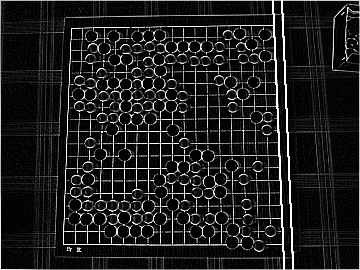

In [504]:
arr2=arr.copy()
draw_line(arr2, (600, 400), 300, 40)
draw_line(arr2, (600, 400), 296, 75)
draw_line(arr2, (600, 400), 296, 79)
arr2 = arr2.astype(np.uint8)
Image.fromarray(arr2)

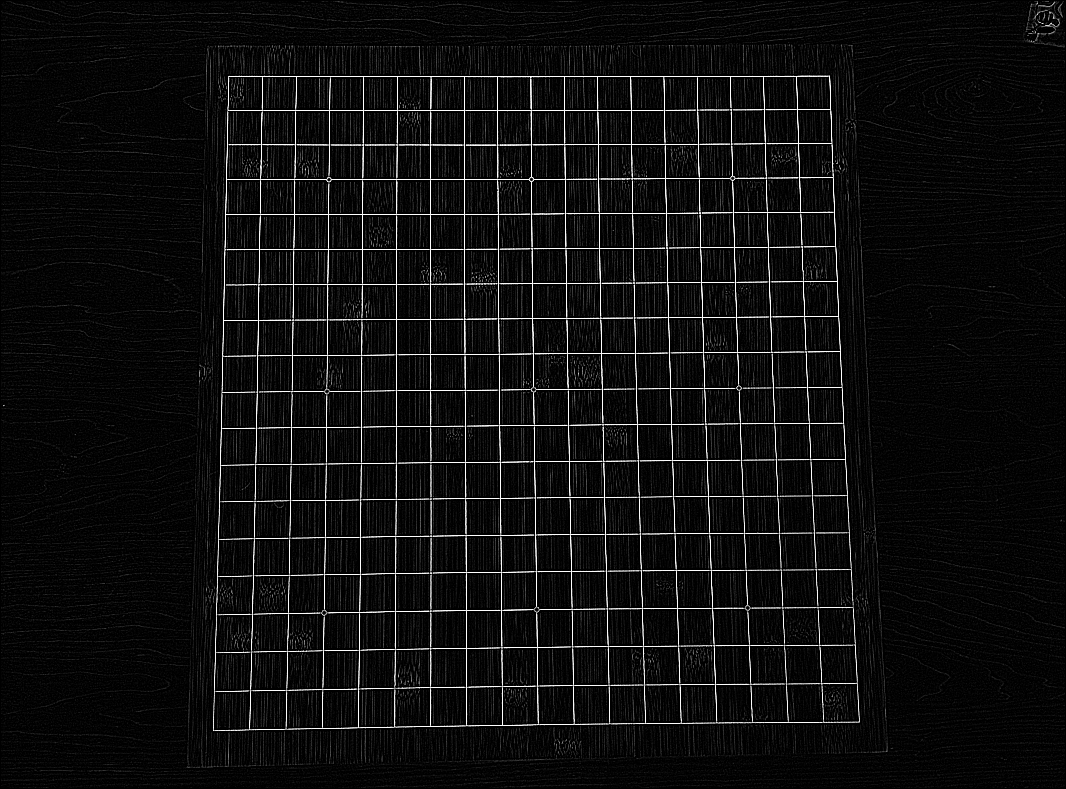

In [11]:
Image.fromarray(arr.astype(np.uint8))

In [110]:
cProfile.run("im2 = transform(arr, (600, 400))")

         7 function calls in 50.618 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   50.618   50.618 <string>:1(<module>)
        1   50.618   50.618   50.618   50.618 __init__.py:25(transform)
        1    0.000    0.000   50.618   50.618 {built-in method exec}
        3    0.001    0.000    0.001    0.000 {built-in method zeros}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [671]:
x = transform(arr, (600, 400))
y = (x*255 / x.max()).astype(np.uint8)

61344000


In [40]:
arr.dtype

dtype('float64')

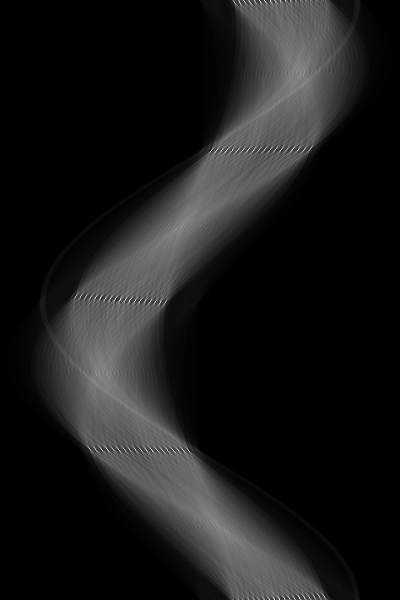

In [111]:
y = (im2*255 / im2.max()).astype(np.uint8)
Image.fromarray(y)

Image.fromarray(y_b)

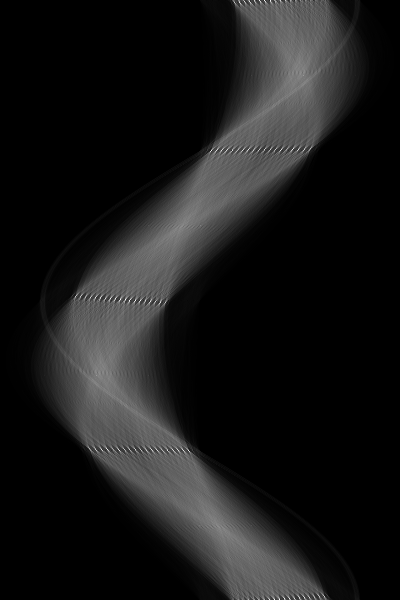

In [112]:
y = (arr2*255 / arr2.max()).astype(np.uint8)
Image.fromarray(y)

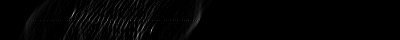

In [728]:
a = filters.gaussian_filter(x, 0.5)  - filters.gaussian_filter(x, 4)
for (i,j) in product(range(a.shape[0]), range(a.shape[1])):
    a[i,j] = max(a[i,j], 0)
a /= a.max()
b = (a*255).astype(np.uint8)
Image.fromarray(b[280:320, :])

[(151, 200), (451, 199), (149, 202), (449, 197)]


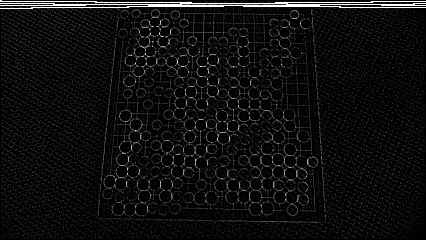

In [676]:
offsets = b.argsort(axis=None)[::-1][:4]
q=[ (o // b.shape[1], o % b.shape[1]) for o in offsets]
arr2=arr.copy()
print(q)
for (p,l) in q:
  #   if 110 <= p <= 200:
        draw_line(arr2, (600, 400), p,l)
arr2 = arr2.astype(np.uint8)
Image.fromarray(arr2)

In [711]:
def good(lst, val, period):
    for t in lst:
        q = (val - t + 5*period)% period
        if q < (period // 10) or (q > period - (period//10)):
            return False
    return True

In [737]:
def good2(lst, val):
    (x_v, y_v) = val
    for (x, y) in lst:
        if (x-x_v)*(x-x_v) + (y-y_v)*(y-y_v) <= 7:
            return False
    return True

In [747]:
def get_band(ba, start, stop):
    offsets = ba.argsort(axis=None)[::-1]
    q=[ (o // ba.shape[1], o % ba.shape[1]) for o in offsets]
    l=[]
    for (u, v) in q:
        if start <= u <= stop and good2(l, (u,v)):
            l.append((u,v))
    return l

In [755]:
def draw_band(ba, start, stop, img):
    s = get_band(ba, start, stop)[:20]
    for (p,l) in s:
        draw_line(img, (600, 400), p,l)

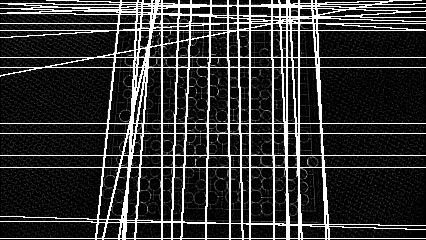

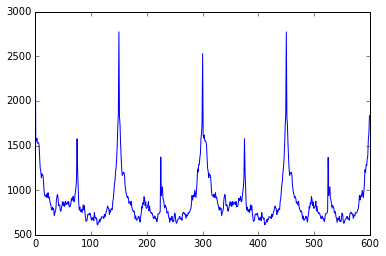

In [757]:
xx = np.zeros(b.shape[0])
for i in range(b.shape[0]):
    xx[i] = b[i].sum()

plt.plot(range(len(xx)), xx)
period = 300
dd = xx.argsort()[::-1]
l = []
for i in range(2):
    for j in range(len(dd)):
        if good(l, dd[j], period) and (period//10 < dd[j] < 2*period - (period//10)):
            l.append(dd[j])
            break
arr2 = arr.copy()        
for i in l:
    draw_band(b, i-30, i+30, arr2)
Image.fromarray(arr2.astype(np.uint8))
    

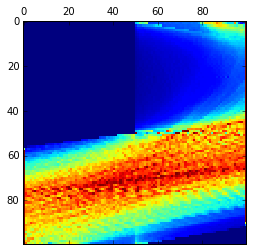

In [139]:
plt.matshow(y)

In [106]:
y.max

<function ndarray.max>

In [107]:
y.max()

7632739.0

In [137]:
z=np.zeros((100, 100))
z[30,30] = 255
z[30, 43] = 255
t = transform(z, 100, 100)

1000000


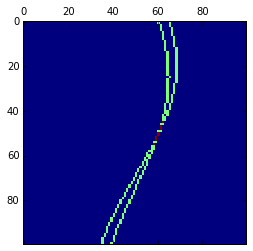

In [136]:
%%cython --cplus

cimport numpy as cnp
cimport cython

@cython.overflowcheck(False)
@cython.boundscheck(False)plt.matshow(t)

In [115]:
arr2 = np.zeros((600, 400))
transform_c(arr, arr2)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [53]:
%%cython --cplus

cimport numpy as cnp
cimport cython
from libcpp.vector cimport vector

@cython.overflowcheck(False)
@cython.boundscheck(False)



def siema(float a, float b):
    return int(a) + <int>(b)
    

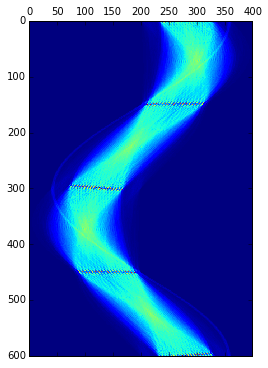

In [105]:
plt.matshow(arr2)

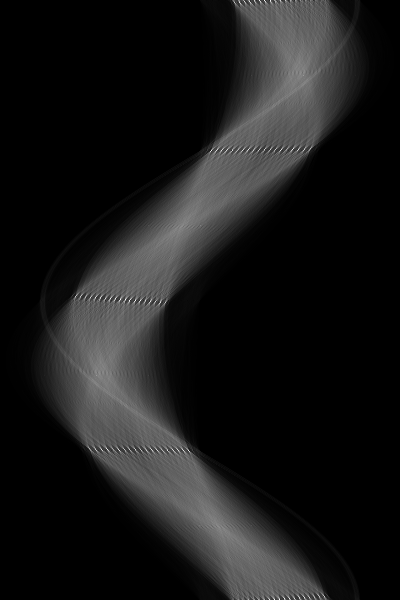

In [106]:
y = (arr2*255 / arr2.max()).astype(np.uint8)
Image.fromarray(y)

In [37]:
x[:,np.newaxis,np.newaxis].repeat(3, axis=1).repeat(4, axis=2)

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]]])

In [56]:
t=np.ones(12).reshape(3,4)

In [57]:
t

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]])

In [60]:
t[1, np.array([2,2,3,1])]  += [3,3,3,3]

In [61]:
t

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  4.,  4.,  4.],
       [ 1.,  1.,  1.,  1.]])

In [50]:
np.array([2,2,3,1])

array([2, 2, 3, 1])

In [1]:
import numpy as np

In [2]:
%load_ext cython

In [23]:
def array_sum_py(x):
    res = 0
    for n1 in x:
        for n2 in x:
            for n3 in x:
                res += n1 + n2 + n3
                res %= 100000
    return res

In [27]:
%%cython --cplus

cimport numpy as cnp
cimport cython

@cython.overflowcheck(False)
@cython.boundscheck(False)
def array_sum(cnp.ndarray x):
    cdef int res = 0
    cdef int n1
    cdef int n2
    cdef int n3
    cdef int size = x.shape[0]
    cdef int [:] buff = x
    for n1 in range(size):
        for n2 in range(size):
            for n3 in range(size):
                res += buff[n1] + buff[n2] + buff[n3]
                res %= 100000
    return res % 100000

In [28]:
import cProfile

cProfile.run("array_sum(example)")

         4 function calls in 0.755 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.755    0.755 <string>:1(<module>)
        1    0.755    0.755    0.755    0.755 {_cython_magic_5c5d3620f9b6431a06c79d42cffed839.array_sum}
        1    0.000    0.000    0.755    0.755 {built-in method exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [24]:
cProfile.run("array_sum_py(example)")

         4 function calls in 41.883 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   41.883   41.883   41.883   41.883 <ipython-input-23-7035b73b9459>:1(array_sum_py)
        1    0.000    0.000   41.883   41.883 <string>:1(<module>)
        1    0.000    0.000   41.883   41.883 {built-in method exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


